In [1]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from IPython.display import Image, display
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import matplotlib as plt
import cv2 as cv
from PIL import Image
import os


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:

print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Tensorflow version: 2.6.4
Keras version: 2.6.0


In [3]:
# Image('/kaggle/input/ice-cream-dataset/combined/images/1_breyers.png')
# cv.imshow("a",img)
# cv.waitKey(0) 
# cv.destroyAllWindows() 
from IPython.display import HTML
from base64 import b64encode

def show_image(path_to_image, width=None, height=None):

    mime_type = None
    path_to_image = path_to_image.lower()

    # More MIME types:
    # https://developer.mozilla.org/en-US/docs/Web/HTTP/Basics_of_HTTP/MIME_types
    if path_to_image.endswith('.jpg') or path_to_image.endswith('.jpeg'):
        mime_type = 'image/jpeg'
    elif path_to_image.endswith('.png'):
        mime_type = 'image/png'
    elif path_to_image.endswith('.gif'):
        mime_type = 'image/gif'
    else:
        raise ValueError('Unknown extension: %s' % (path_to_image))

    img = open(path_to_image, 'rb').read()
    data_url = 'data:image/jpeg;base64,' + b64encode(img).decode()

    width_str = "width='%d'" % (width) if width is not None else ''
    height_str = "height='%d'" % (width) if height is not None else ''

    display(HTML("<img src='%s' %s%s>" % (data_url, width_str, height_str)))

In [4]:
train_breyers = ["../input/ice-cream-dataset/breyers/images/11_breyers.png","../input/ice-cream-dataset/breyers/images/12_breyers.png","../input/ice-cream-dataset/breyers/images/13_breyers.png","../input/ice-cream-dataset/breyers/images/14_breyers.png","../input/ice-cream-dataset/breyers/images/15_breyers.png"]
test_breyers = ["../input/ice-cream-dataset/breyers/images/16_breyers.png","../input/ice-cream-dataset/breyers/images/17_breyers.png","../input/ice-cream-dataset/breyers/images/18_breyers.png","../input/ice-cream-dataset/breyers/images/19_breyers.png","../input/ice-cream-dataset/breyers/images/20_breyers.png"]
train_talenti = ["../input/ice-cream-dataset/talenti/images/11_talenti.png","../input/ice-cream-dataset/talenti/images/12_talenti.png","../input/ice-cream-dataset/talenti/images/13_talenti.png","../input/ice-cream-dataset/talenti/images/14_talenti.png","../input/ice-cream-dataset/talenti/images/15_talenti.png"]  
test_talenti = ["../input/ice-cream-dataset/talenti/images/16_talenti.png","../input/ice-cream-dataset/talenti/images/17_talenti.png","../input/ice-cream-dataset/talenti/images/18_talenti.png","../input/ice-cream-dataset/talenti/images/19_talenti.png","../input/ice-cream-dataset/talenti/images/20_talenti.png","../input/ice-cream-dataset/talenti/images/21_talenti.png"]
print("h")

h


In [5]:
def create_dir(path):
    if  os.path.exists(path) != True:
        os.mkdir(path)
        print(path+" -> created")
    else:
        print(path+" -> exists")

In [6]:
create_dir('/kaggle/working/proj0622')
create_dir('/kaggle/working/proj0622/images')
create_dir('/kaggle/working/proj0622/images/train')
create_dir('/kaggle/working/proj0622/images/test')


/kaggle/working/proj0622 -> created
/kaggle/working/proj0622/images -> created
/kaggle/working/proj0622/images/train -> created
/kaggle/working/proj0622/images/test -> created


In [7]:
def create_images(target_dir, source_arr):
    for i in range(0,len(source_arr)):
    
        image = cv.imread(source_arr[i])
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
        reshape_image = cv.resize(gray, (100, 100),interpolation = cv.INTER_NEAREST)
    
    
        head, tail = os.path.split(source_arr[i])
        imgfile = target_dir + "/" + tail
            
        if os.path.isfile(imgfile) != True:
            
            cv.imwrite(imgfile,reshape_image)                
            print("created: "+ imgfile)
            
        else: 
            print("Exists: "+ imgfile)
    
   

In [8]:
train_dir = '/kaggle/working/proj0622/images/train'
test_dir = '/kaggle/working/proj0622/images/test'

create_images(train_dir,train_breyers)
create_images(train_dir,train_talenti)
create_images(test_dir,test_breyers)
create_images(test_dir,test_talenti)

created: /kaggle/working/proj0622/images/train/11_breyers.png
created: /kaggle/working/proj0622/images/train/12_breyers.png
created: /kaggle/working/proj0622/images/train/13_breyers.png
created: /kaggle/working/proj0622/images/train/14_breyers.png
created: /kaggle/working/proj0622/images/train/15_breyers.png
created: /kaggle/working/proj0622/images/train/11_talenti.png
created: /kaggle/working/proj0622/images/train/12_talenti.png
created: /kaggle/working/proj0622/images/train/13_talenti.png
created: /kaggle/working/proj0622/images/train/14_talenti.png
created: /kaggle/working/proj0622/images/train/15_talenti.png
created: /kaggle/working/proj0622/images/test/16_breyers.png
created: /kaggle/working/proj0622/images/test/17_breyers.png
created: /kaggle/working/proj0622/images/test/18_breyers.png
created: /kaggle/working/proj0622/images/test/19_breyers.png
created: /kaggle/working/proj0622/images/test/20_breyers.png
created: /kaggle/working/proj0622/images/test/16_talenti.png
created: /kagg


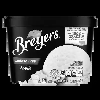


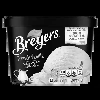


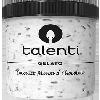


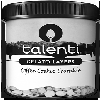


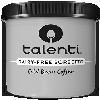


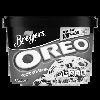


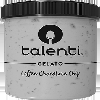


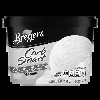


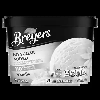


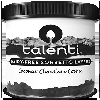

In [9]:

x = os.listdir(train_dir)
for f in x:
    show_image(train_dir + "/"+ f)


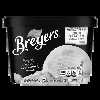


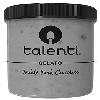


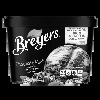


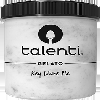


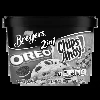


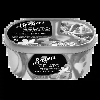


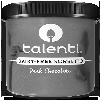


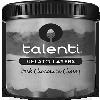


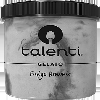


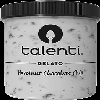


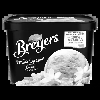

In [10]:
x = os.listdir(test_dir)
for f in x:
    show_image(test_dir + "/"+ f)

In [11]:
# show_image('/kaggle/working/proj0622/images/train/13_talenti.png')

In [12]:
# path ='/kaggle/working/proj0622/images/train/'
# x = os.listdir(path)
# for f in x:
#    show_image(path + f)


In [13]:
# path ='/kaggle/working/proj0622/images/test/'
# x = os.listdir(path)
# for f in x:
#    show_image(path + f)

In [14]:

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(input_shape = (150,150,3)),
#     tf.keras.layers.Dense(512,activation = "relu"),
#     tf.keras.layers.Dense(2,activation="softmax")
    
# ])
# model.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics=["accuracy"])
# #model.fit(...,epochs = 100)



In [15]:
print('done')

done
